# TASK 02- Image Classification Using Bag of Visual Words

In [3]:
import argparse
import cv2
import numpy as np 
import os
import io
from pandas import DataFrame
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from skimage import io, data, exposure, morphology
from tqdm import tqdm
import joblib
import time

## Functions

In [4]:
def show(img):
    io.imshow(img)
    plt.show()
    
def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def getimages(path_train,path_test):
    images_train=[]
    images_test=[]

    for folder in os.listdir(path_train):
        if folder!=".DS_Store":
            for file in os.listdir(os.path.join(path_train,folder)):
                    images_train.append(os.path.join(path_train, os.path.join(folder,file)))
    np.random.shuffle(images_train)
    
    if path_test!=False:
        for folder in os.listdir(path_test):
            if folder!=".DS_Store":
                for file in os.listdir(os.path.join(path_test,folder)):
                        images_test.append(os.path.join(path_test, os.path.join(folder,file)))
                    
        return images_train,images_test
    else:
        return images_train

def vstackthenkmean(descriptor_list,no_clusters):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractScaleFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
            
    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    return im_features

def svcParamSelection(X, y, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def trainSVM (X,y,params_svc):
    C_param, gamma_param = params_svc.get("C"), params_svc.get("gamma")
    class_weight = {
        0: (3670 / (5 * 633)),
        1: (3670 / (5 * 898)),
        2: (3670 / (5 * 641)),
        3: (3670 / (5 * 699)),
        4: (3670 / (5 * 799)),
    }

    svc=svm.SVC(C =  C_param, gamma = gamma_param)
    svc.fit(X,y)
    
    return svc

sift = cv2.xfeatures2d.SIFT_create()

# Bag of Visual words classifier for Objects Dataset

## Labeling the images

In [5]:
def label_des_objectsBovW(images,sift):
    class_index=[]
    descriptor_list = []
    for img_path in images:
        if("accordion" in img_path):
            class_index.append(0)
        elif("dollar_bill" in img_path):
            class_index.append(1)
        elif("motorbike" in img_path):
            class_index.append(2)
        elif("Soccer_Ball" in img_path):
            class_index.append(3)
                
        img = readImage(img_path)
        kp, des = sift.detectAndCompute(img, None)
        descriptor_list.append(des)
            
    labels=np.array([class_index])
            
    return class_index,labels,descriptor_list

In [8]:
noclusters=5
nfolds=5

#Defining the path for dataset
path_train='/Users/admin/Documents/3rdSem/CV/Assignment01/Q2/Objects_Dataset_Images/Train'
path_test='/Users/admin/Documents/3rdSem/CV/Assignment01/Q2/Objects_Dataset_Images/Test'

#Load Images
images_train,images_test=getimages(path_train,path_test)
img_count_train=len(images_train)
img_count_test=len(images_test)

#Labeling & getting descriptors for Training Data
class_index_train,train_labels,descriptor_list_train=label_des_objectsBovW(images_train,sift)
#Labeling & getting descriptors for testing data
class_index_test,test_labels,descriptor_list_test=label_des_objectsBovW(images_test,sift)

#Getting kmeans after vstacking descriptors 
kmeans_train=vstackthenkmean(descriptor_list_train,noclusters)
kmeans_test=vstackthenkmean(descriptor_list_test,noclusters)

#Extracting and scaling features
im_features_train=extractScaleFeatures(kmeans_train, descriptor_list_train, img_count_train, noclusters)
im_features_test=extractScaleFeatures(kmeans_test, descriptor_list_test, img_count_test, noclusters)

#Grid search for SVM Parameters
train_labels=train_labels.T.ravel()
params=svcParamSelection(im_features_train,train_labels, nfolds)

#Train SVM model
svc=trainSVM(im_features_train,train_labels,params)

# Saving the SVM model
f1= 'SVM_model_objects.sav'
joblib.dump(svc,f1)

['SVM_model_objects.sav']

In [9]:
#Loading the saved model
svc=joblib.load('SVM_model_objects.sav')

#Predicting values
y_pred_svc=svc.predict(im_features_test)
test_labels=test_labels.ravel()

In [12]:
print("Accuracy for object classification : "+str(accuracy_score(test_labels, y_pred_svc)))
print('\n')
print(classification_report(test_labels, y_pred_svc,zero_division=1))

Accuracy for object classification : 0.75


              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2
           2       0.50      0.50      0.50         2
           3       1.00      1.00      1.00         2

    accuracy                           0.75         8
   macro avg       0.79      0.75      0.74         8
weighted avg       0.79      0.75      0.74         8



Text(0.5, 0, '')

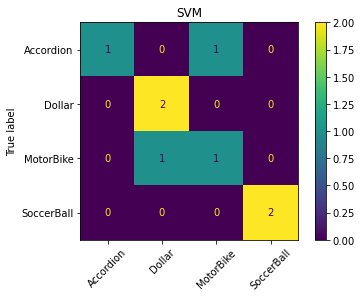

In [13]:
Index1=['Accordion','Dollar','MotorBike','SoccerBall']
#Confusion matrix for SVM model
cf_matrix1 = confusion_matrix(test_labels, y_pred_svc)
disp = ConfusionMatrixDisplay(cf_matrix1,display_labels=Index1)
disp.plot(xticks_rotation=45)
disp.ax_.set_title("SVM")
disp.ax_.set_xlabel('')

## SOME OUTPUTS FOR OBJECT CLASSIFICATION

Some correctly classified images for Object Classification

Classified as Dollar


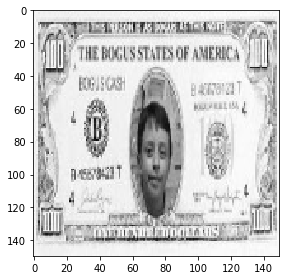


Classified as SoccerBall


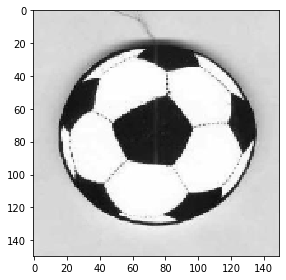

In [37]:
svm_mismatch=[]
svm_match=[]
count=0
for i in y_pred_svc:
    if i!=test_labels[count]:
        svm_mismatch.append(count)
    else:
        svm_match.append(count)
    count=count+1
len(svm_mismatch)

#Correctly Classified
print('Some correctly classified images for Object Classification')
print('\nClassified as '+str(Index1[y_pred_svc[svm_match[1]]]))
img1=readImage(images_test[svm_match[1]])
show(img1)
print('\nClassified as '+str(Index1[y_pred_svc[svm_match[2]]]))
img3=readImage(images_test[svm_match[2]])
show(img3)

Some Missclassified images for Object Classification

Classified as MotorBike


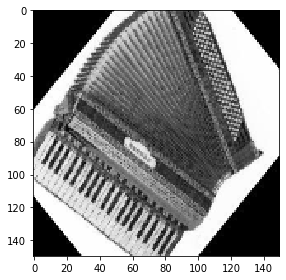


Classified as Dollar


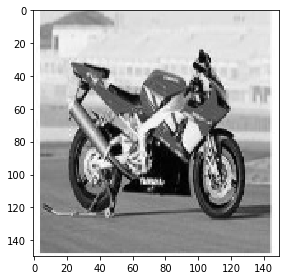

In [56]:
#Not Correctly Classified
print('Some Missclassified images for Object Classification')
print('\nClassified as '+str(Index1[y_pred_svc[svm_mismatch[0]]]))
img5=readImage(images_test[svm_mismatch[0]])
show(img5)
print('\nClassified as '+str(Index1[y_pred_svc[svm_mismatch[1]]]))
img7=readImage(images_test[svm_mismatch[1]])
show(img7)

## Bag of Visual words classifier for Flower Dataset
# Labeling the images

In [14]:
def label_des_flowerBovW(images,sift):
    class_index=[]
    descriptor_list = []
    for img_path in images:
        if("daisy" in img_path):
            class_index.append(0)
        elif("dandelion" in img_path):
            class_index.append(1)
        elif("roses" in img_path):
            class_index.append(2)
        elif("sunflowers" in img_path):
            class_index.append(3)
        elif("tulips" in img_path):
            class_index.append(4)
          
        
        img = readImage(img_path)
        kp, des = sift.detectAndCompute(img, None)
        descriptor_list.append(des)
            
    labels=np.array([class_index])
            
    return class_index,labels,descriptor_list

In [15]:
#Defining the path for dataset
path_images='/Users/admin/Documents/3rdSem/CV/Assignment01/Q2/flower_photos'

#Load Images
images_flowers=getimages(path_images,False)
img_count_flowers=len(images_flowers)

#Labeling & getting descriptors for All images
class_index_flowers,labels_flowers,descriptor_list_flowers=label_des_flowerBovW(images_flowers,sift)


In [17]:
#Getting kmeans after vstacking descriptors 
kmeans_flowers=vstackthenkmean(descriptor_list_flowers,noclusters)

#Extracting and scaling features
im_features_flowers=extractScaleFeatures(kmeans_flowers, descriptor_list_flowers, img_count_flowers, noclusters)

In [27]:
#Splitting the data into training and testing
X_train_flowers, X_test_flowers, y_train_flowers, y_test_flowers = train_test_split(im_features_flowers, labels_flowers.T.ravel(), test_size=0.3, random_state=0)

#Grid search for SVM Parameters
y_train_flowers=y_train_flowers.T.ravel()
params_flowers=svcParamSelection(X_train_flowers, y_train_flowers, nfolds)

In [28]:
#Train SVM model
svc1=trainSVM(X_train_flowers, y_train_flowers,params)

# Saving the SVM model
f2= 'SVM_model_flowers.sav'
joblib.dump(svc1,f2)

['SVM_model_flowers.sav']

In [29]:
#Loading the saved model
svc1=joblib.load('SVM_model_flowers.sav')

#Predicting values
y_pred_svc_flowers=svc1.predict(X_test_flowers)
y_test_flowers=y_test_flowers.ravel()

In [30]:
print("Accuracy: "+str(accuracy_score(y_test_flowers, y_pred_svc_flowers)))
print('\n')
print(classification_report(y_test_flowers, y_pred_svc_flowers,zero_division=1))

Accuracy: 0.3106267029972752


              precision    recall  f1-score   support

           0       0.35      0.11      0.16       190
           1       0.32      0.64      0.43       273
           2       0.29      0.14      0.19       204
           3       0.28      0.33      0.30       209
           4       0.32      0.22      0.26       225

    accuracy                           0.31      1101
   macro avg       0.31      0.29      0.27      1101
weighted avg       0.31      0.31      0.28      1101



Text(0.5, 0, '')

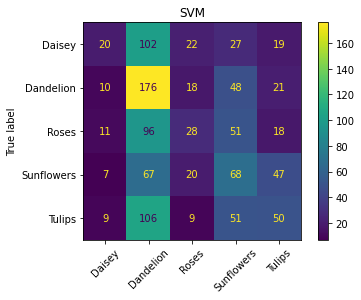

In [31]:
Index= ['Daisey','Dandelion','Roses','Sunflowers','Tulips']

#Confusion matrix for SVM model
cf_matrix2 = confusion_matrix(y_test_flowers, y_pred_svc_flowers)
disp = ConfusionMatrixDisplay(cf_matrix2,display_labels=Index)
disp.plot(xticks_rotation=45)
disp.ax_.set_title("SVM")
disp.ax_.set_xlabel('')

## SOME OUTPUTS FOR FLOWER CLASSIFICATION

Some correctly classified images for Flowers Classification

Classified as Roses


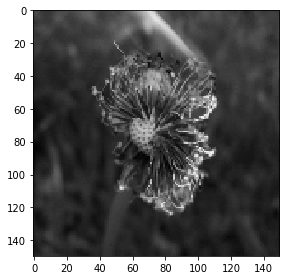


Classified as Tulips


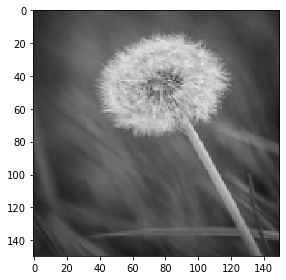

In [55]:
rfc_mismatch=[]
rfc_match=[]
count=0
for i in y_pred_svc_flowers:
    if i!=y_test_flowers[count]:
        rfc_mismatch.append(count)
    else:
        rfc_match.append(count)
    count=count+1

#Correctly Classified
print('Some correctly classified images for Flowers Classification')
print('\nClassified as '+str(Index[y_pred_svc_flowers[rfc_match[1]]]))
img12=readImage(images_flowers[rfc_match[1]])
show(img12)
print('\nClassified as '+str(Index[y_pred_svc_flowers[rfc_match[3]]]))
img32=readImage(images_flowers[rfc_match[2]])
show(img32)

Some correctly misclassified images for Flowers Classification

Classified as Roses


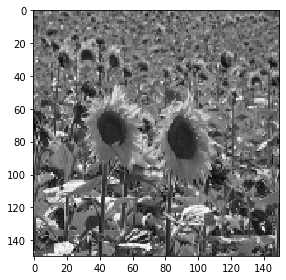


Classified as Dandelion


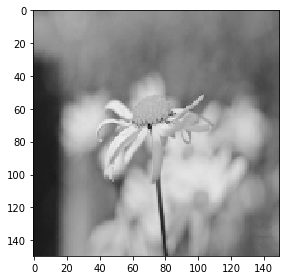

In [57]:
#Not Correctly Classified
print('Some correctly misclassified images for Flowers Classification')
print('\nClassified as '+str(Index[y_pred_svc_flowers[rfc_mismatch[1]]]))
img122=readImage(images_flowers[rfc_mismatch[1]])
show(img122)
print('\nClassified as '+str(Index[y_pred_svc_flowers[rfc_mismatch[100]]]))
img322=readImage(images_flowers[rfc_mismatch[100]])
show(img322)